# Case Study - Term Deposit

**Author:** Priya Sharma

**Email:** priyasharma1908@gmail.com

## Objective

The objective of this report is to present the analysis and results from modeling client data to predict if client will subscribe to term deposit.

We have followed the **scientific method** for this analysis and have broken down the steps as follows:

* **Objective**

* **Research**

* **Hypothesis**

* **Analysis**

* **Conclusion**

In [1]:
# Loading required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import shap

from dython.nominal import theils_u, correlation_ratio
from pandas.api.types import is_numeric_dtype
from scipy import stats
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load dataset
term_deposit_data = pd.read_csv("./bank-additional-full.csv", sep=";")

## Research

### Term Deposit

* A term deposit is a type of deposit account held at a financial institution where money is locked up for some set period of time.

* Term deposits are usually short-term deposits with maturities ranging from one month to a few years.

* Typically, term deposits offer higher interest rates than traditional liquid savings accounts, whereby customers can withdraw their money at any time.

## User defined functions

In [3]:
# Utility functions
def remove_rows_with_unknowns(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to drop rows having 'unknown' values for any variable.
    
    Args:
        df: Dataframe
    
    Returns:
        Dataframe without any 'unknown' values
    """
    return(df[~df.replace('unknown', np.nan).isna().sum(axis=1).astype('bool')])

def min_max_scaling(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to scale numeric columns of train and test dataframes using MinMaxScaler
    
    Args:
        train_df: Training dataframe. Scaler will be built using this
        test_df: Test dataframe. Scaler built from train would be applied on test
        
    Returns:
        Dataframe with scaled numeric columns
    """
    for column in train_df.columns:
        if(is_numeric_dtype(train_df[column])):
            scaler = MinMaxScaler()
            train_df[column] = scaler.fit_transform(train_df[[column]])
            test_df[column] = scaler.transform(test_df[[column]])
    return(train_df, test_df)

def compute_correlation(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to compute correlation values as follows:
    - Pearson correlation (numeric-numeric)
    - Correlation Ratio (numeric-categorical)
    - Theil's U (categorical-categorical)
    
    Args:
        df: Dataset for which to compute correlation matrix
        
    Returns:
        Correlation matrix as dataframe
    """
    # Get list of columns
    list_of_columns = df.columns
    
    # Initialize empty dataframe for correlation matrix
    corr_df = pd.DataFrame(index=list_of_columns, columns=list_of_columns)
    
    # Iterate over each column
    for i in range(len(list_of_columns)):
        # For each column, iterate over list of columns again to get pair-wise columns
        # Note: We are iterating over (i, j) and (j, i) separately as Theil's U is not symmetric
        for j in range(len(list_of_columns)):
            if is_numeric_dtype(df[list_of_columns[i]]):
                if is_numeric_dtype(df[list_of_columns[j]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[j]], df[list_of_columns[i]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            elif is_numeric_dtype(df[list_of_columns[j]]):
                if is_numeric_dtype(df[list_of_columns[i]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            else:
                # Case 3: Both are categorical
                corr_value = theils_u(df[list_of_columns[i]], df[list_of_columns[j]])
                corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
    return(pd.DataFrame(corr_df.astype('float64').round(2)))

def get_model_summary(model:'sklearn.linear_model.LogisticRegression', X:'pd.DataFrame', y:'pd.Series')->'pd.DataFrame':
    """
    Function to compute model summary for sklearn Logistic Regression model as sklearn does not have
    implimentation of the same.
    
    Args:
        model: sklearn.linear_model.LogitsticRegression model object
        X: DataFrame with independent variables from training set
        y: Series with dependent variable from training set
        
    Returns:
        DataFrame containing model summary
    """
    # Extract model parameters
    params = np.append(model.intercept_, model.coef_)
    
    # Make predictions for training set (Fitted values)
    predictions = model.predict(X)
    
    # Original dataset with column 'Constant' for intercept
    newX = pd.DataFrame({
        "Constant": np.ones(len(X))
    }).join(pd.DataFrame(X).reset_index(drop=True))
    
    # Compute t stat and p value
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    
    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)))) for i in ts_b]
    
    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)
    
    # Return model summary as DataFrame
    myDF3 = pd.DataFrame(index = newX.columns)
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    
    return(myDF3)

def missing_value_mode_treatment(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'tuple':
    """
    Function to impute missing values using mode of the variable.
    
    Args:
        train_df: Training dataset
        test_df: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Get columns with unknown values
    unknown_count = train_df.replace('unknown', np.nan).isna().sum(axis=0)
    unknown_columns = list(unknown_count[unknown_count > 0].index)
    
    # For each column
    for column in unknown_columns:
        # Get mode
        mode_value = train_df[column].mode()[0]
        
        # Update unknown with mode in training set
        train_df[column] = train_df[column].replace("unknown", np.nan).fillna(mode_value)
        
        # Update unknown with model in test set
        test_df[column] = test_df[column].replace("unknown", np.nan).fillna(mode_value)
    return(train_df, test_df)

def remove_outliers_iqr(train_x:'pd.DataFrame', test_x:'pd.DataFrame')->'tuple':
    """
    Function to remove outliers using Inter Quartile Range method
    
    Args:
        train_x: Training dataset
        test_x: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Compute Q1 and Q3
    q1 = np.quantile(train_x, 0.25)
    q3 = np.quantile(train_x, 0.75)
    
    # Compute IQR
    iqr = q3 - q1
    
    # Get upper and lower limits
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    
    # Cap outliers to upper and lower limits
    train_x[train_x < lower_limit] = lower_limit
    train_x[train_x > upper_limit] = upper_limit
    test_x[test_x < lower_limit] = lower_limit
    test_x[test_x > upper_limit] = upper_limit
    return(train_x, test_x)

## Hypothesis

The hypothesis for this analysis is as follows:

**A combination of CLIENT DATA, LAST CONTACT DATA and ADDITIONAL ATTRIBUTES can be used to predict if client will subscribe to a term deposit.**

* A term deposit is a type of deposit account held at a financial institution where money is locked up for some set period of time.

* Term deposits are usually short-term deposits with maturities ranging from one month to a few years.

* Typically, term deposits offer higher interest rates than traditional liquid savings accounts, whereby customers can withdraw their money at any time.

## User defined functions

In [3]:
# Utility functions
def remove_rows_with_unknowns(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to drop rows having 'unknown' values for any variable.
    
    Args:
        df: Dataframe
    
    Returns:
        Dataframe without any 'unknown' values
    """
    return(df[~df.replace('unknown', np.nan).isna().sum(axis=1).astype('bool')])

def min_max_scaling(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to scale numeric columns of train and test dataframes using MinMaxScaler
    
    Args:
        train_df: Training dataframe. Scaler will be built using this
        test_df: Test dataframe. Scaler built from train would be applied on test
        
    Returns:
        Dataframe with scaled numeric columns
    """
    for column in train_df.columns:
        if(is_numeric_dtype(train_df[column])):
            scaler = MinMaxScaler()
            train_df[column] = scaler.fit_transform(train_df[[column]])
            test_df[column] = scaler.transform(test_df[[column]])
    return(train_df, test_df)

def compute_correlation(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to compute correlation values as follows:
    - Pearson correlation (numeric-numeric)
    - Correlation Ratio (numeric-categorical)
    - Theil's U (categorical-categorical)
    
    Args:
        df: Dataset for which to compute correlation matrix
        
    Returns:
        Correlation matrix as dataframe
    """
    # Get list of columns
    list_of_columns = df.columns
    
    # Initialize empty dataframe for correlation matrix
    corr_df = pd.DataFrame(index=list_of_columns, columns=list_of_columns)
    
    # Iterate over each column
    for i in range(len(list_of_columns)):
        # For each column, iterate over list of columns again to get pair-wise columns
        # Note: We are iterating over (i, j) and (j, i) separately as Theil's U is not symmetric
        for j in range(len(list_of_columns)):
            if is_numeric_dtype(df[list_of_columns[i]]):
                if is_numeric_dtype(df[list_of_columns[j]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[j]], df[list_of_columns[i]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            elif is_numeric_dtype(df[list_of_columns[j]]):
                if is_numeric_dtype(df[list_of_columns[i]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            else:
                # Case 3: Both are categorical
                corr_value = theils_u(df[list_of_columns[i]], df[list_of_columns[j]])
                corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
    return(pd.DataFrame(corr_df.astype('float64').round(2)))

def get_model_summary(model:'sklearn.linear_model.LogisticRegression', X:'pd.DataFrame', y:'pd.Series')->'pd.DataFrame':
    """
    Function to compute model summary for sklearn Logistic Regression model as sklearn does not have
    implimentation of the same.
    
    Args:
        model: sklearn.linear_model.LogitsticRegression model object
        X: DataFrame with independent variables from training set
        y: Series with dependent variable from training set
        
    Returns:
        DataFrame containing model summary
    """
    # Extract model parameters
    params = np.append(model.intercept_, model.coef_)
    
    # Make predictions for training set (Fitted values)
    predictions = model.predict(X)
    
    # Original dataset with column 'Constant' for intercept
    newX = pd.DataFrame({
        "Constant": np.ones(len(X))
    }).join(pd.DataFrame(X).reset_index(drop=True))
    
    # Compute t stat and p value
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    
    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)))) for i in ts_b]
    
    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)
    
    # Return model summary as DataFrame
    myDF3 = pd.DataFrame(index = newX.columns)
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    
    return(myDF3)

def missing_value_mode_treatment(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'tuple':
    """
    Function to impute missing values using mode of the variable.
    
    Args:
        train_df: Training dataset
        test_df: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Get columns with unknown values
    unknown_count = train_df.replace('unknown', np.nan).isna().sum(axis=0)
    unknown_columns = list(unknown_count[unknown_count > 0].index)
    
    # For each column
    for column in unknown_columns:
        # Get mode
        mode_value = train_df[column].mode()[0]
        
        # Update unknown with mode in training set
        train_df[column] = train_df[column].replace("unknown", np.nan).fillna(mode_value)
        
        # Update unknown with model in test set
        test_df[column] = test_df[column].replace("unknown", np.nan).fillna(mode_value)
    return(train_df, test_df)

def remove_outliers_iqr(train_x:'pd.DataFrame', test_x:'pd.DataFrame')->'tuple':
    """
    Function to remove outliers using Inter Quartile Range method
    
    Args:
        train_x: Training dataset
        test_x: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Compute Q1 and Q3
    q1 = np.quantile(train_x, 0.25)
    q3 = np.quantile(train_x, 0.75)
    
    # Compute IQR
    iqr = q3 - q1
    
    # Get upper and lower limits
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    
    # Cap outliers to upper and lower limits
    train_x[train_x < lower_limit] = lower_limit
    train_x[train_x > upper_limit] = upper_limit
    test_x[test_x < lower_limit] = lower_limit
    test_x[test_x > upper_limit] = upper_limit
    return(train_x, test_x)

## Hypothesis

The hypothesis for this analysis is as follows:

**A combination of CLIENT DATA, LAST CONTACT DATA and ADDITIONAL ATTRIBUTES can be used to predict if client will subscribe to a term deposit.**

## Analysis

In this section, we will perform **experiments** and gather **insights** using our dataset to prove our hypothesis. This analysis has been broken down in the following steps:

* Data Exploration

* Statistical Analysis

* Data Preprocessing

* Predictive Modeling and Model Interpretation

### Data Exploration

In this section, we will explore the dataset that will be used to create the final model.

#### Data Dictionary

A data dictionary which will describe the contents, format and structure of the dataset.

##### Independent Variables

In [4]:
outDf = pd.DataFrame({
    "Variable": list(term_deposit_data.columns)[:-1],
    "Description": ["Age of client",
                    "Type of job",
                    "Marital status",
                    "Educational qualifications",
                    "If client has credit in default",
                    "If client has a housing loan",
                    "If client has a personal loan",
                    "Contact communication type",
                    "Last contact month of year",
                    "Last contact day of the week",
                    "Last contact duration in seconds",
                    "Number of contacts performed during this campaign for this client",
                    "Number of days since client was last contacted from previous campaign. (999 code for no previous contact)",
                    "Number of contacts performed before this campaign",
                    "Outcome of the previous marketing campaign",
                    "Employment variation rate (Quarterly indicator)",
                    "Consumer price index (Monthly indicator)",
                    "Consumer confidence index (Monthly indicator)",
                    "Euribor 3 month rate (Daily indicator)",
                    "Number of employees (Quarterly indicator)"],
    "Sample Values": list(term_deposit_data[term_deposit_data.columns[:-1]].apply(lambda x: ','.join([str(ele) for ele in x.unique()[:3] if ele != "unknown"] + ["..."]), axis=0)),
    "Data Types": list(term_deposit_data.dtypes[:-1])
})

outDf.style.set_properties(subset='Description', **{'min-width': '300px'})

,Variable,Description,Sample Values,Data Types
0,age,Age of client,"56,57,37,...",int64
1,job,Type of job,"housemaid,services,admin.,...",object
2,marital,Marital status,"married,single,divorced,...",object
3,education,Educational qualifications,"basic.4y,high.school,basic.6y,...",object
4,default,If client has credit in default,"no,yes,...",object
5,housing,If client has a housing loan,"no,yes,...",object
6,loan,If client has a personal loan,"no,yes,...",object
7,contact,Contact communication type,"telephone,cellular,...",object
8,month,Last contact month of year,"may,jun,jul,...",object
9,day_of_week,Last contact day of the week,"mon,tue,wed,...",object


##### Dependent Variable

In [5]:
outDf = pd.DataFrame({
    "Variable": list(term_deposit_data.columns)[-1],
    "Description": ["Has the client subscribed to a term deposit."],
    "Sample Values": [','.join(list(term_deposit_data[term_deposit_data.columns[-1]].unique()))]
})

outDf.style.set_properties(subset='Description', **{'min-width': '300px'})

,Variable,Description,Sample Values
0,y,Has the client subscribed to a term deposit.,"no,yes"


#### Quck Peek

First few samples from the dataset.

In [6]:
term_deposit_data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
print("Shape of dataset is:", term_deposit_data.shape)

Shape of dataset is: (41188, 21)


**Findings:** Data has

* 41188 samples

* 20 independent variables

* 1 dependent variable

#### Missing Values

In [8]:
term_deposit_data.replace("unknown", np.nan).isna().sum(axis=0).reset_index().rename(columns={0: 'Count of Missing Values',
                                                                                              'index': 'Variable'})

,Variable,Count of Missing Values
0,age,0
1,job,330
2,marital,80
3,education,1731
4,default,8597
5,housing,990
6,loan,990
7,contact,0
8,month,0
9,day_of_week,0


**Findings**

* Missing values are only present in categorical columns

* Missing values are present in variables under **client data** umbrella, but not in variables under **last contact** or **additional attributes**

### Statistical Analysis

Statistical analysis is the collection and interpretation of data in order to uncover patterns and trends.

#### Univariate Analysis

It considers only one variable at a time to find patterns within that variable.

##### Data Distribution

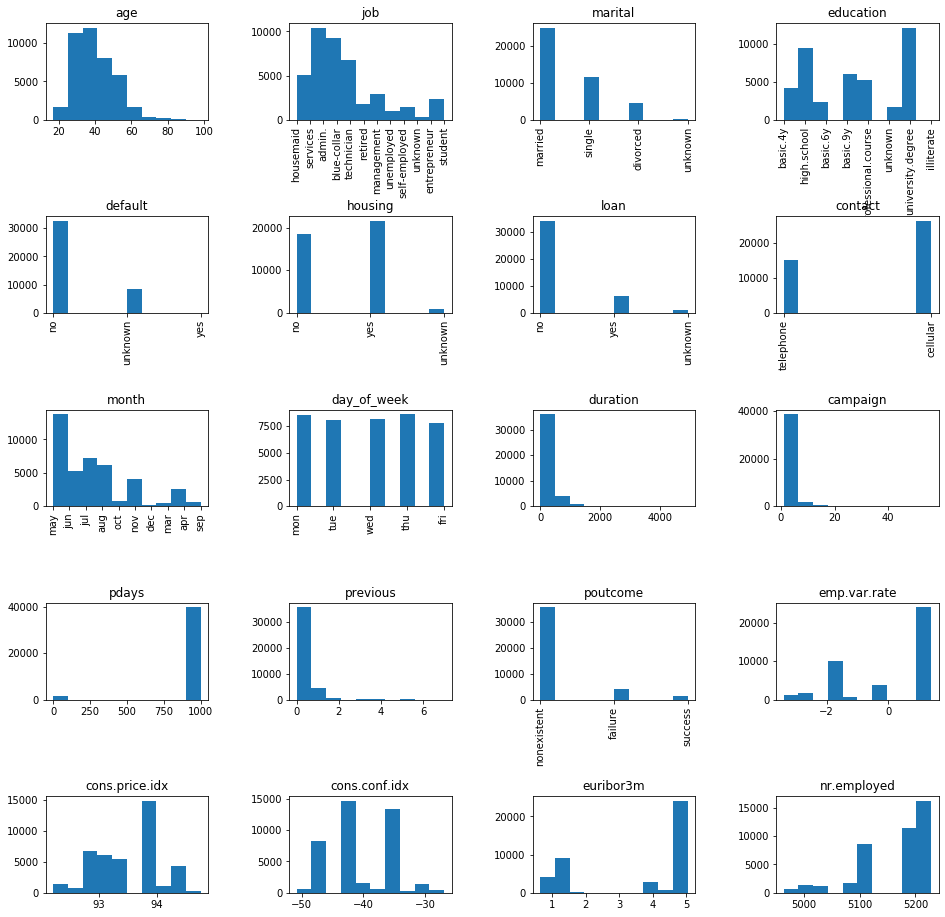

In [9]:
fig, axes = plt.subplots(5, 4, figsize = (16, 16))
fig.subplots_adjust(hspace = 1, wspace = 0.5)
axes = axes.ravel()
kwargs = {'alpha': 1}

for i, column in enumerate(term_deposit_data.columns[:-1]):
    column_series = term_deposit_data[column]
    
    axes[i].hist(column_series, **kwargs)
    axes[i].set_title(column)
    
    if(column_series.dtype == 'object'):
        axes[i].tick_params(axis='x', labelrotation=90)
plt.show()

**Findings**

* Most clients belong to the ages between 20-60. It is intuitive as these are the ages when people are looking for investment opportunities

* Highest number of clients are ones with a university degree

* 70% of the clients are new as they have **pdays** as 999 (have not been contacted previously). This can also be seen in **poutcome** (which has 70% nonexistent previous outcomes) and **previous** (70% having 0 previous contacts). Hence, these 3 variables should have higher correlation

###### Independent Variable

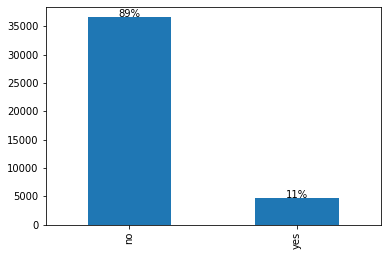

In [10]:
ax = term_deposit_data['y'].value_counts().plot.bar()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height / term_deposit_data.shape[0]:.0%}', (x + width/2, y + height + 10), ha='center')

**Findings**

* The dataset is imbalanced, with higher number of negative samples

##### Discriptive Statistics

This includes:

* **Mean**: The arithmetic mean or average is given by the sum of all observations divided by the total number of observations

* **Std**: The standard deviation is the average deviation of values from their mean

* **Min**: Minimum value

* **25%**: First quartile, indicates value below which 25% of the values of the data fall

* **50%**: Second quartile (median), indicates value below which 50% of the values of the data fall

* **75%**: Third quartile, indicates value below which 75% of the values of the data fall

* **Max**: Maximum value

In [11]:
term_deposit_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Findings**

* For **age**, mean and median values are relatively close, so the distribution is closer to a normal distribution

* For **campaign**, though mean and median are close, the max value is very high, showing a possibility of outlier in the variable

##### Boxplots

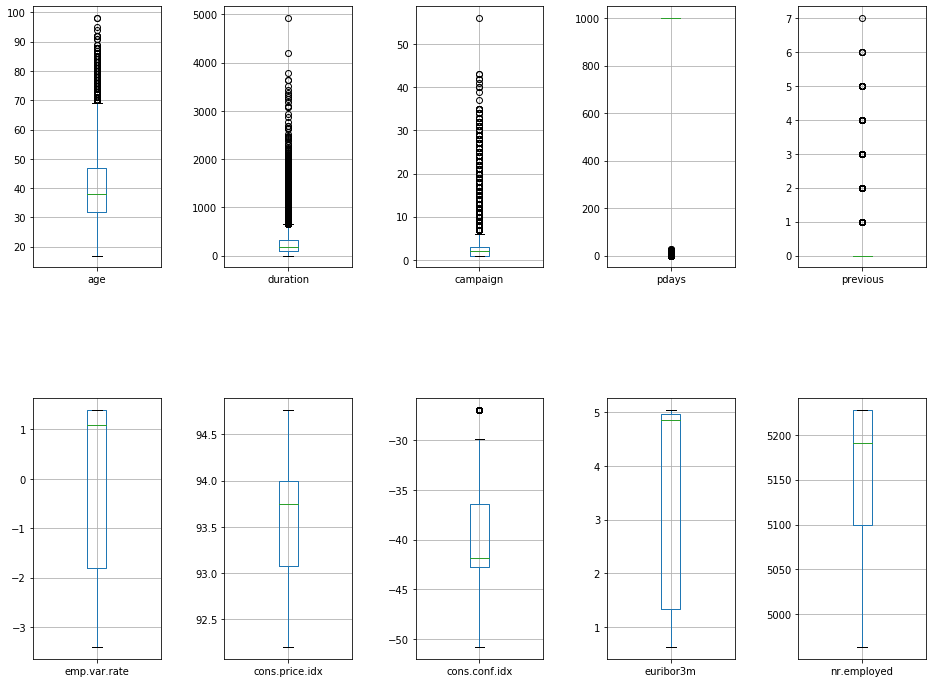

In [12]:
fig, axes = plt.subplots(2, 5, figsize = (16, 12))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
axes = axes.ravel()

i = 0
for column in term_deposit_data.columns[[is_numeric_dtype(term_deposit_data[column]) for column in term_deposit_data.columns]]:
    column_series = term_deposit_data[column]
    
    term_deposit_data[[column]].boxplot(ax=axes[i])
    i += 1
plt.show()

**Findings**

* There are outliers in **age**, **duration**, **campaign** and **cons.conf.idx**

* Outliers in **previous** can be ignored as majority of values in previous are 0 (new clients), hence cannot be used to decide the cut-off for outliers

#### Bivariate Analysis

Bivariate analysis involves the analysis of two variables for the purpose of determining the empirical relationship between them.

##### Correlation Plot

In this section, we will compute pair-wise correlation between features. The correlation coefficients considered are as follows:

* **Pearson Correlation:** It shows the co-movement of two variables and is applicable when both variables are numerical

* **Correlation Ratio:** It defines, given a continuous number, how well can the category for that number be found and is applicable when one variable is numerical and the other is categorical

* **Theil's U:** The Uncertainty Coefficient, is based on the conditional entropy between x and y, and defines how many and how frequenctly occuring states does y have for a given x. It is applicable when both variables are categorical

In [13]:
correlation_df = compute_correlation(term_deposit_data)

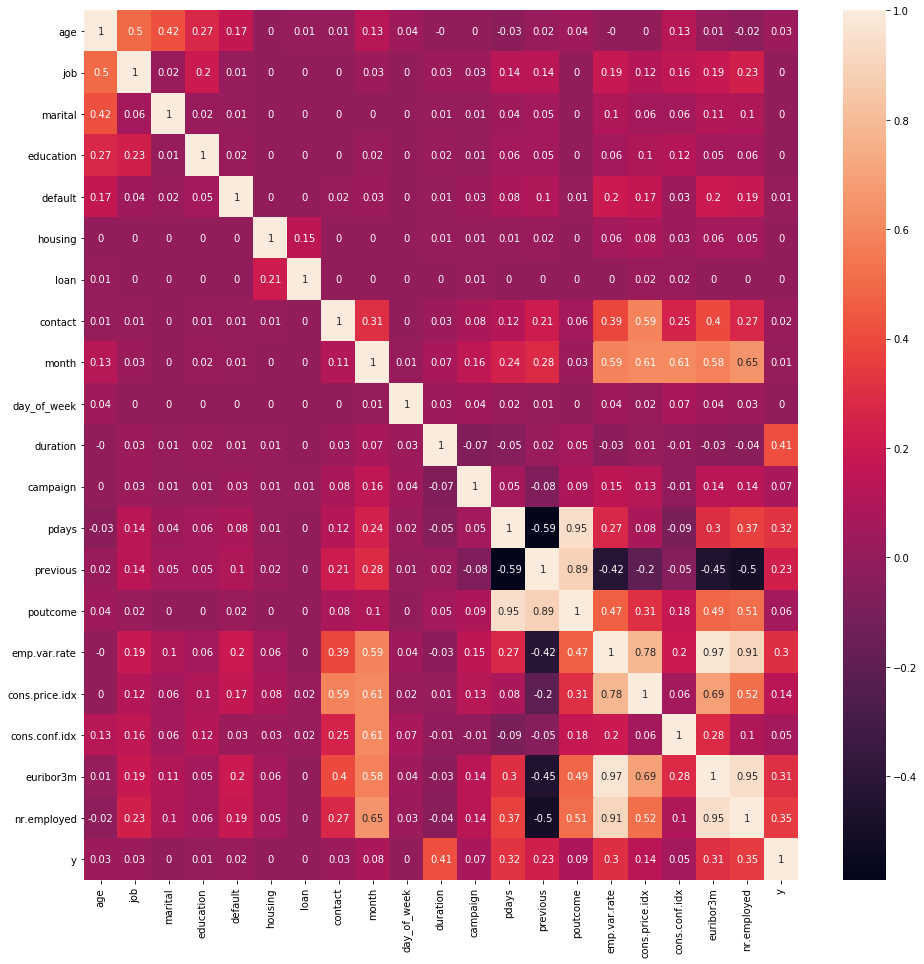

In [14]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(correlation_df, annot=True)
plt.show()

**Findings**

* **poutcome** has a high correlation with **pdays** and **previous**

* **nr.employed** has a high correlation with **euribor3m**

##### Data Distribution

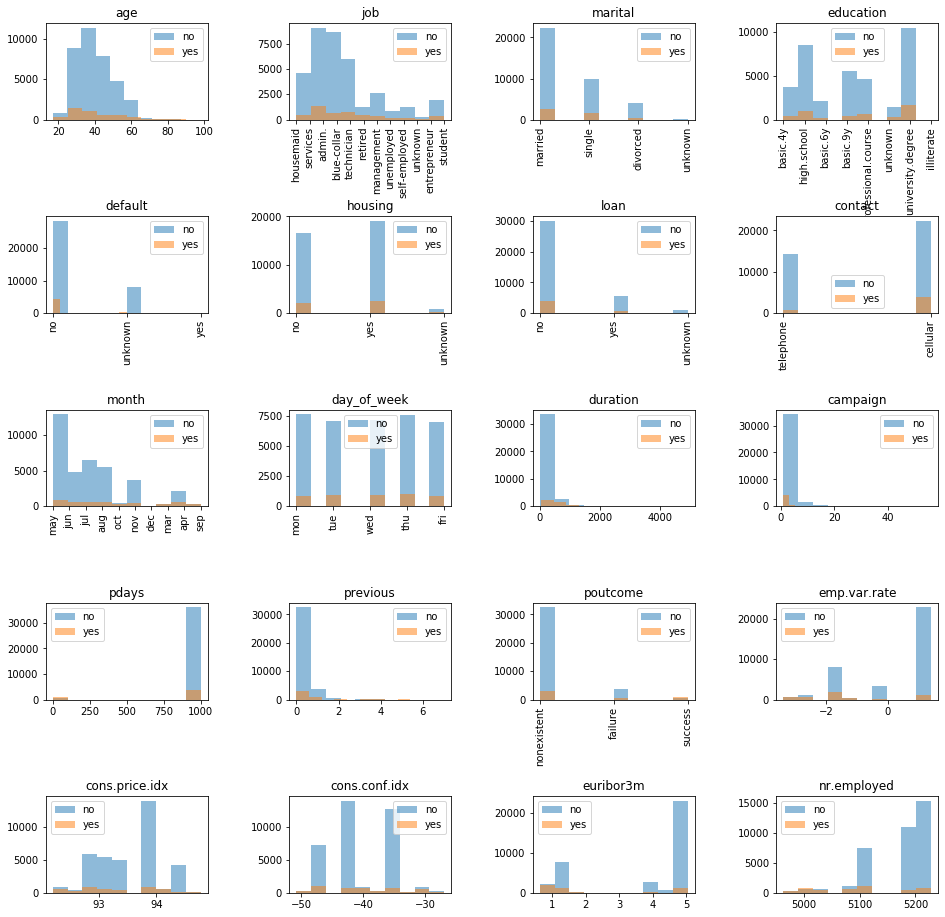

In [15]:
fig, axes = plt.subplots(5, 4, figsize = (16, 16))
fig.subplots_adjust(hspace = 1, wspace = 0.5)
axes = axes.ravel()
kwargs = {'alpha': 0.5}

for i, column in enumerate(term_deposit_data.columns[:-1]):
    column_series = term_deposit_data[column]
    sample_class = term_deposit_data['y']
    
    axes[i].hist(column_series[sample_class == 'no'], **kwargs, label='no')
    axes[i].hist(column_series[sample_class == 'yes'], **kwargs, label='yes')
    axes[i].legend()
    axes[i].set_title(column)
    
    if(column_series.dtype == 'object'):
        axes[i].tick_params(axis='x', labelrotation=90)
plt.show()

**Findings**

* Though there is an imbalance in the number of negative and positive samples, the distribution within each group is similar

##### Boxplots

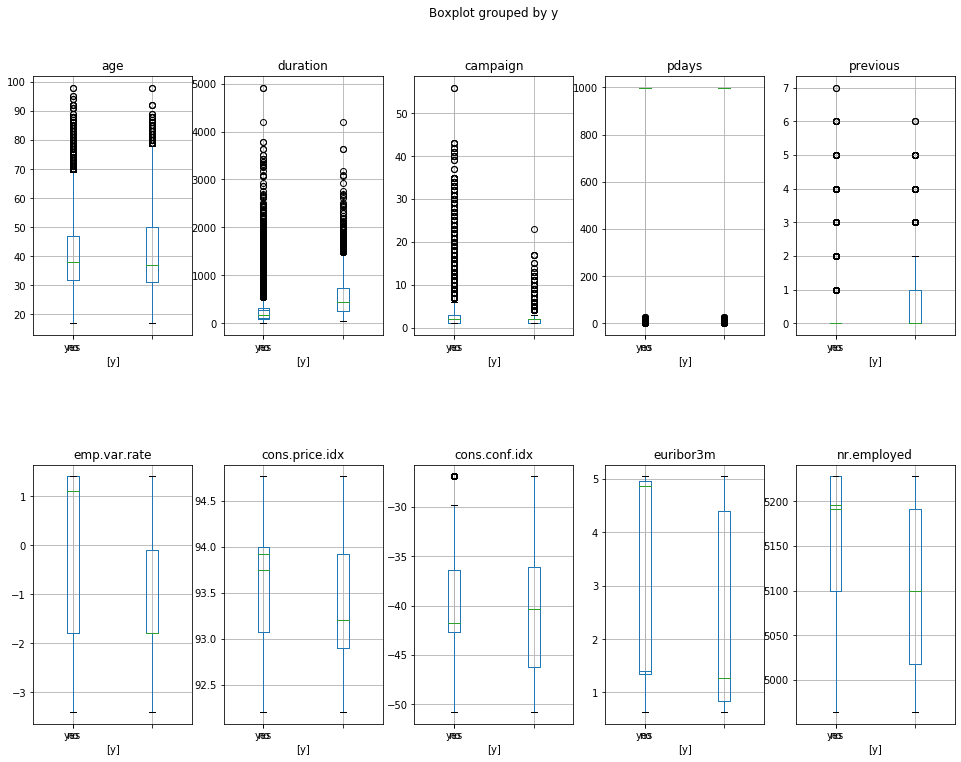

In [16]:
fig, axes = plt.subplots(2, 5, figsize = (16, 12))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
axes = axes.ravel()

i = 0
for column in term_deposit_data.columns[[is_numeric_dtype(term_deposit_data[column]) for column in term_deposit_data.columns]]:
    column_series = term_deposit_data[column]
    sample_class = term_deposit_data['y']
    
    term_deposit_data[[column]].boxplot(ax=axes[i])
    term_deposit_data[[column, 'y']].boxplot(by='y', ax=axes[i])
    i += 1
plt.show()

**Findings**

* Distribution is similar for negative and positive samples